In [389]:
path = "../results/gsm8k/llama/CAPO/seed42/benchmark_experiment_gsm8k_llama_CAPO_42/4a7ed6c7986d10c96da8ff5875d45cfceda504e4c14d828bec5010882f5eb1be/step_results.parquet"

In [390]:
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob

In [391]:
df = pd.read_parquet(glob(path, recursive=True)[0])
df

,step,timestamp,time_elapsed,score,prompt,input_tokens_meta_llm,output_tokens_meta_llm,input_tokens_downstream_llm,output_tokens_downstream_llm
0,1,2025-03-21 20:08:51.548190,425.965386,0.866667,Break down this word problem carefully. Rememb...,1285,471,190919,92241
1,1,2025-03-21 20:08:51.548190,425.965386,0.866667,Calling all math wizards! I need help with thi...,1285,471,190919,92241
2,1,2025-03-21 20:08:51.548190,425.965386,0.833333,Please analyze this elementary school math pro...,1285,471,190919,92241
3,1,2025-03-21 20:08:51.548190,425.965386,0.833333,I'm having trouble with this grade school math...,1285,471,190919,92241
4,1,2025-03-21 20:08:51.548190,425.965386,0.800000,Analyze and solve the following elementary sch...,1285,471,190919,92241
...,...,...,...,...,...,...,...,...,...
145,15,2025-03-21 21:55:15.755714,518.595694,0.763333,I'm having trouble with this grade school math...,1667,675,324392,151116
146,15,2025-03-21 21:55:15.755714,518.595694,0.756667,I'm struggling to crack this complex math word...,1667,675,324392,151116
147,15,2025-03-21 21:55:15.755714,518.595694,0.756667,I'm struggling to solve a complex math word pr...,1667,675,324392,151116
148,15,2025-03-21 21:55:15.755714,518.595694,0.756667,Calling all math wizards! I need help with thi...,1667,675,324392,151116


In [392]:
df["total_tokens"] = (
    df["output_tokens_meta_llm"]
    + df["input_tokens_meta_llm"]
    + df["output_tokens_downstream_llm"]
    + df["input_tokens_downstream_llm"]
)
df["total_tokens"] = df["total_tokens"].cumsum()

In [393]:
# cum of tokens
df["output_tokens_downstream_llm_cum"] = df["output_tokens_downstream_llm"].cumsum()
df["output_tokens_meta_llm_cum"] = df["output_tokens_meta_llm"].cumsum()
df["input_tokens_downstream_llm_cum"] = df["input_tokens_downstream_llm"].cumsum()
df["input_tokens_meta_llm_cum"] = df["input_tokens_meta_llm"].cumsum()

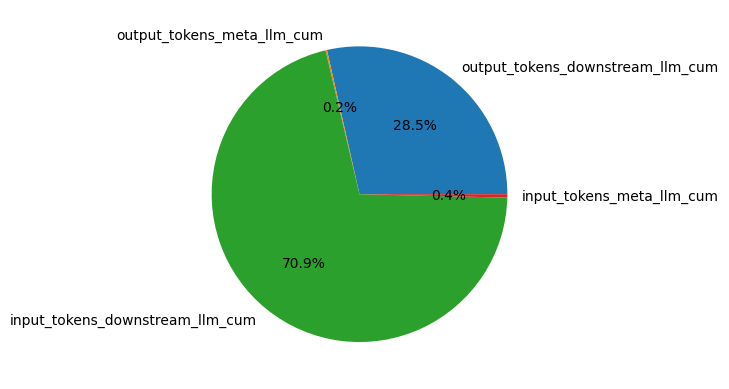

In [394]:
# plot pie
fig, ax = plt.subplots()
ax.pie(
    [
        df["output_tokens_downstream_llm_cum"].iloc[-1],
        df["output_tokens_meta_llm_cum"].iloc[-1],
        df["input_tokens_downstream_llm_cum"].iloc[-1],
        df["input_tokens_meta_llm_cum"].iloc[-1],
    ],
    labels=[
        "output_tokens_downstream_llm_cum",
        "output_tokens_meta_llm_cum",
        "input_tokens_downstream_llm_cum",
        "input_tokens_meta_llm_cum",
    ],
    autopct="%1.1f%%",
)
plt.show()

In [395]:
df["n_shots"] = df["prompt"].str.count("Input:") - 1

In [396]:
print(df["prompt"].sample(1).item())

Help me crack a tricky grade school math puzzle that demands a series of logical steps to unravel. Could you dissect this math problem, typically taught in elementary school, into bite-sized components, offer a step-by-step explanation of your thought process, and then encapsulate the final solution within <final_answer> tags to make it easily accessible?

Input:
It took Alice three months to save up to buy new shoes. If she saved 10 dollars the first month and 30 more each month, how much did she have saved by the end of the third month?
Output:
<final_answer>70</final_answer>

Input:
Jane is sewing sequins onto her trapeze artist costume. She sews 6 rows of 8 blue sequins each, 5 rows of 12 purple sequins each, and 9 rows of 6 green sequins each. How many sequins does she add total?
Output:
To find the total number of sequins Jane adds, we need to calculate the number of sequins for each color and then add them together.

First, let's calculate the number of blue sequins:
6 rows * 8 

In [397]:
df["prompt_len"] = df["prompt"].str.len()

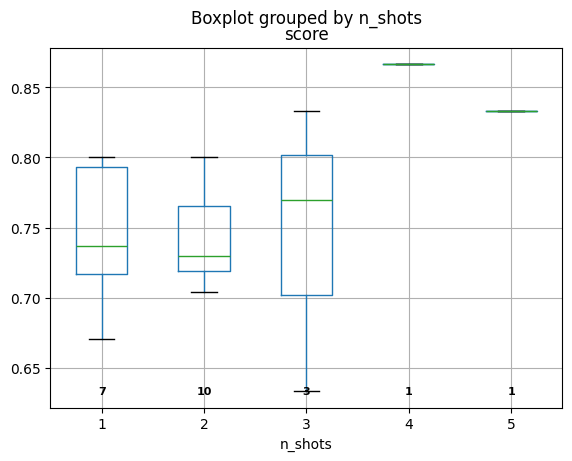

In [398]:
# correlation between number shots and score => boxplot, and give number of samples per n_shots
fig = df.groupby("prompt").first().boxplot(column="score", by="n_shots", showfliers=False)
# add number of samples (unique prompts!) per n_shots
num_samples = df.groupby(["prompt", "n_shots"]).size().reset_index().groupby("n_shots").size()
for i, n in enumerate(num_samples):
    fig.text(
        i + 1,
        df["score"].min(),
        n,
        ha="center",
        va="center",
        rotation=0,
        fontsize=8,
        color="black",
        fontweight="bold",
    )

plt.show();

In [399]:
# group df by step and get the mean of the values (ignore stings)
df_grouped = df.groupby("step", as_index=False).mean(numeric_only=True)
# df_grouped["cum_input_tokens"] = df_grouped["input_tokens_downstream_llm"].cumsum()

# join the maximum score for each step
df_grouped = df_grouped.join(
    df.groupby("step", as_index=False).max()[["step", "score"]].set_index("step"),
    on="step",
    rsuffix="_max",
)

df_grouped

,step,time_elapsed,score,input_tokens_meta_llm,output_tokens_meta_llm,input_tokens_downstream_llm,output_tokens_downstream_llm,total_tokens,output_tokens_downstream_llm_cum,output_tokens_meta_llm_cum,input_tokens_downstream_llm_cum,input_tokens_meta_llm_cum,n_shots,prompt_len,score_max
0,1,425.965386,0.780000,1285.0,471.0,190919.0,92241.0,1567038.0,507325.5,2590.5,1050054.5,7067.5,2.5,1908.8,0.866667
1,2,301.080627,0.741667,1451.0,614.0,208411.0,93018.0,4518377.0,1434009.0,8087.0,3055450.5,20830.5,2.2,1778.0,0.816667
2,3,1370.180388,0.740952,1465.0,613.0,1016462.0,385111.0,13604180.5,3970700.5,14221.5,9583841.0,35417.5,2.2,1778.0,0.833333
3,4,644.011813,0.737917,1569.0,725.0,444500.0,189329.0,23419286.5,6745009.5,20967.5,16602670.0,50639.5,2.2,1858.0,0.829167
4,5,259.410348,0.741250,1741.0,841.0,163309.0,72834.0,27594827.5,7997577.0,28855.5,19501119.5,67275.5,2.3,1945.0,0.829167
5,6,1046.662909,0.759000,1527.0,640.0,748508.0,296541.0,34428778.0,9956305.5,36160.0,24352804.0,83508.5,2.3,1947.1,0.840000
6,7,338.390731,0.759000,1510.0,617.0,217495.0,81924.0,40799753.0,11741322.0,42433.5,28917312.5,98685.0,2.3,1947.1,0.840000
7,8,423.253795,0.759333,1611.0,703.0,306248.0,90033.0,44348982.5,12605161.5,49076.5,31580404.0,114340.5,2.4,2154.0,0.840000
8,9,365.142402,0.763667,1676.0,802.0,233606.0,87057.0,47919935.5,13489123.5,56651.0,34243353.0,130808.0,2.5,2023.0,0.840000
9,10,220.926082,0.763667,1601.0,769.0,144628.0,51893.0,50467970.5,14166291.5,64489.5,36090034.0,147155.5,2.5,2023.0,0.840000


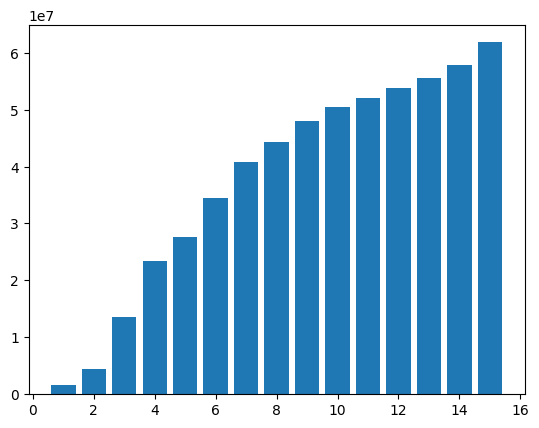

In [400]:
# plot step vs total tokens
plt.bar(df_grouped["step"], df_grouped["total_tokens"]);

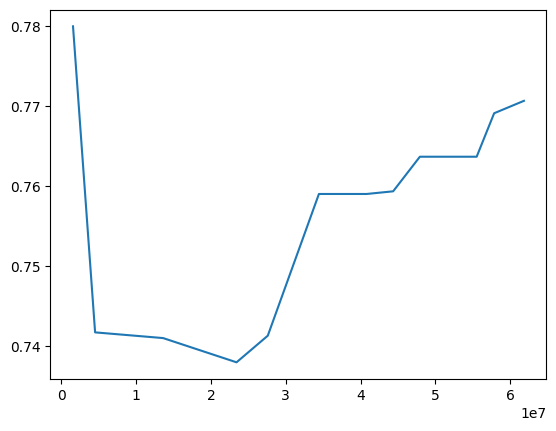

In [401]:
# plot token count vs step and adapt y-axis to min and max
column = "score"
plt.plot(df_grouped["total_tokens"], df_grouped[column])
plt.show();

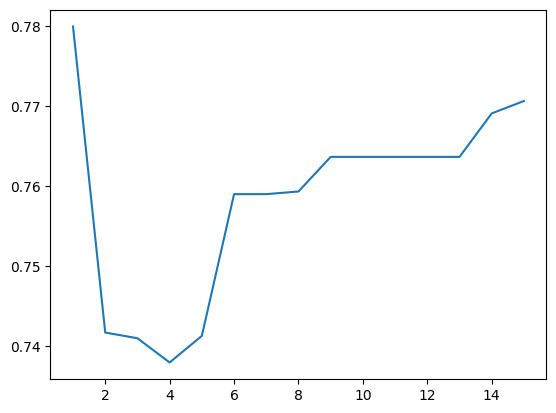

In [402]:
# plot token count vs step and adapt y-axis to min and max
column = "score"
plt.plot(df_grouped["step"], df_grouped[column])
plt.show();

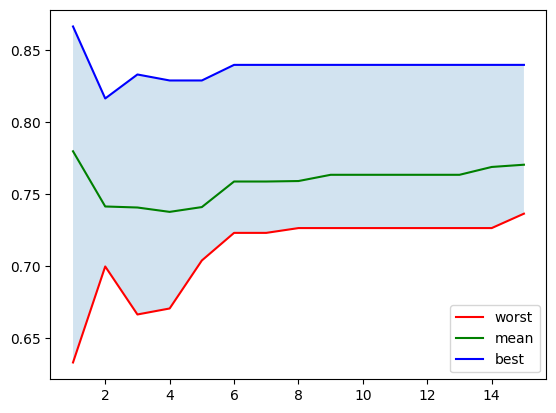

In [403]:
# x_axis => step, y_axis => worst_score, mean_score, best_score
col = "score"

worst_scores = df.groupby("step", as_index=False).min(numeric_only=True)[["step", col]]
mean_scores = df.groupby("step", as_index=False).mean(numeric_only=True)[["step", col]]
best_scores = df.groupby("step", as_index=False).max(numeric_only=True)[["step", col]]

plt.plot(worst_scores["step"], worst_scores[col], label="worst", color="red")
plt.plot(mean_scores["step"], mean_scores[col], label="mean", color="green")
plt.plot(best_scores["step"], best_scores[col], label="best", color="blue")
# fill area between lines
plt.fill_between(mean_scores["step"], worst_scores[col], best_scores[col], alpha=0.2)
plt.legend()
plt.show();

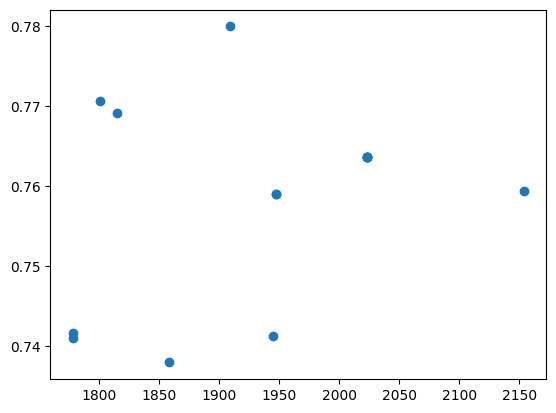

In [404]:
# plot score vs prompt length
plt.scatter(df_grouped["prompt_len"], df_grouped["score"])
plt.show();

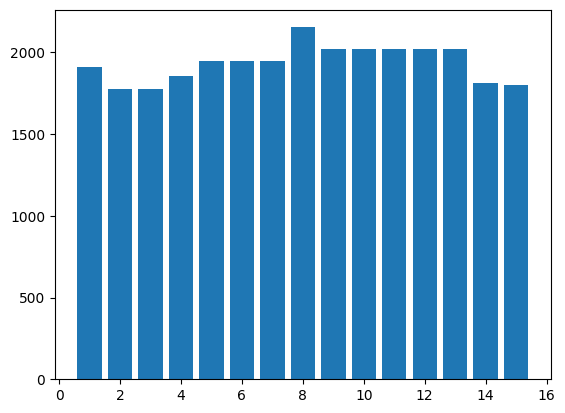

In [405]:
# prompt length vs step
plt.bar(df_grouped["step"], df_grouped["prompt_len"]);

### Analyze best prompts per step

In [406]:
df_best = df.groupby("step").apply(lambda x: x.nlargest(1, "score")).reset_index(drop=True)
# df_best

C:\Users\tzehl\AppData\Local\Temp\ipykernel_23256\373190983.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_best = df.groupby("step").apply(lambda x: x.nlargest(1, "score")).reset_index(drop=True)


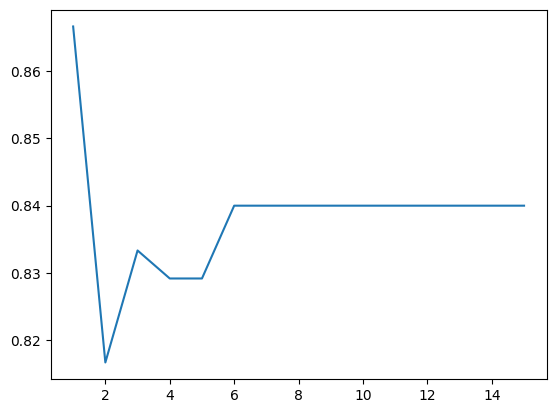

In [407]:
# max a line plot of the best score vs step
plt.plot(df_best["step"], df_best["score"]);

## Analyze Racing

In [408]:
from pprint import pprint as pp

p = lambda x: (pp(x.replace("\r", ""), compact=True, width=200))

In [409]:
df["score"].nlargest(10)

0      0.866667
1      0.866667
50     0.840000
60     0.840000
70     0.840000
80     0.840000
90     0.840000
100    0.840000
110    0.840000
120    0.840000
Name: score, dtype: float64

In [421]:
# best prompt
col = "score"
k_best = 20

best_prompt = df[df[col] == df[col].nlargest(k_best).values[k_best - 1]]
print("unique?", len(best_prompt["prompt"].unique()))
print("number of shots: ", best_prompt["n_shots"].values[0])
print("score: ", best_prompt[col].values[0])
print("first occurence: ", best_prompt["step"].values[0])
print("last occurence: ", best_prompt["step"].values[-1])
print("last train score: ", best_prompt["score"].values[-1].round(2))

p(best_prompt["prompt"].unique()[0])

unique? 3
number of shots:  1
score:  0.8
first occurence:  1
last occurence:  1
last train score:  0.8
('Analyze and solve the following elementary school math problem that requires multiple steps of reasoning. Your final answer must be contained within <final_answer> </final_answer> tags.\n'
 '\n'
 'Input:\n'
 'Kendra has 4 packs of pens. Tony has 2 packs of pens. There are 3 pens in each pack. If Kendra and Tony decide to keep two pens each and give the remaining pens to their friends one pen per '
 'friend, how many friends will they give pens to?\n'
 'Output:\n'
 '<final_answer>14</final_answer>\n'
 '\n'
 'Input:')


In [336]:
print(best_prompt["prompt"].unique()[0])

Classify the given news article into one of the categories (World, Sports, Business, or Sci/Tech) and provide your response within <final_answer> tags for accurate categorization.


In [277]:
best_prompt["prompt"].unique()[0]

"Determine if this sentence is subjective or objective and put your answer between <final_answer> tags.\n\nInput:\nupper west sidey exercise in narcissism and self-congratulation disguised as a tribute .\nOutput:\n<final_answer>Subjective</final_answer>\n\nInput:\nall in all , the count of monte cristo is okay , but it is surely no classic , like the novel upon which it is based .\nOutput:\n<final_answer>Subjective</final_answer>\n\nInput:\nplotless collection of moronic stunts is by far the worst movie of the year .\nOutput:\n<final_answer>Subjective</final_answer>\n\nInput:\nshe 's helped along in that process by betsy wright ( pamela gordon ) , a misanthropic dog-walker in need of help with her business and struggling with her own dark past .\nOutput:\n<final_answer>objective</final_answer>\n\nInput:"

In [278]:
# load the prompt scores per block
path = path.replace("step_results_eval", "prompt_scores")

df_blocks = pd.read_csv(path)
# round all numbers to 2 decimal places
df_blocks = df_blocks.round(2)

df_blocks

OSError: [Errno 22] Invalid argument: '../results/subj/llama/CAPO/seed43/**/step_results.parquet'

In [ ]:
s = df.prompt.sample(1).item()
s

"For this assignment, you'll act as a news classification assistant. Your goal is to carefully analyze the given news article and assign it to one of these four categories: World, Sports, Business, or Sci/Tech. Please format your final response as <final_answer>selected category</final_answer> to facilitate accurate system recognition and smooth processing.\r\n\r\nInput:\r\n<|im_start|>assistant\r\n"

In [ ]:
df_blocks.iloc[2]["Unnamed: 0"]

'Address the math word problem by dissecting it into simpler components for easier resolution. Upon arriving at the solution, make certain that your ultimate answer is enclosed within the <final_answer> and </final_answer> markers.\r\n\r\nInput: A taco truck is selling soft tacos for $2 and hard shell tacos for $5 during the lunch rush. The first group of customers is a family that buys four hard shell tacos and three soft tacos. The rest of the customers in the lunch rush only buy two soft tacos each. There were ten customers after the family. How many dollars did the taco truck make during the lunch rush?\r\nOutput: <final_answer>66</final_answer>\r\n\r\nInput:'

In [ ]:
print(s)

For this assignment, you'll act as a news classification assistant. Your goal is to carefully analyze the given news article and assign it to one of these four categories: World, Sports, Business, or Sci/Tech. Please format your final response as <final_answer>selected category</final_answer> to facilitate accurate system recognition and smooth processing.

Input:
<|im_start|>assistant



In [ ]:
print("\r")

In [ ]:
# get number of blocks per prompt by counting non nans per columns
n_blocks = df_blocks.count(axis=1) - 1

In [ ]:
n_blocks

0       1
1       1
2      10
3      10
4       1
       ..
263     1
264     4
265     1
266    10
267     1
Length: 268, dtype: int64

In [ ]:
df_count = pd.DataFrame({"n_blocks": n_blocks.values, "prompt": df_blocks["Unnamed: 0"]})

In [ ]:
df_count["n_blocks"].value_counts()

n_blocks
1     199
10     32
2      20
4       7
5       4
3       4
6       1
8       1
Name: count, dtype: int64

In [ ]:
# join with df
df_count = df_count.join(df.set_index("prompt"), on="prompt", how="left", lsuffix="_rrr")

# bin by test_score
df_count["test_score_bin"] = pd.cut(df_count["test_score"], bins=5)

ValueError: Bin edges must be unique: Index([nan, nan, nan, nan, nan, nan], dtype='float64').
You can drop duplicate edges by setting the 'duplicates' kwarg

In [ ]:
# evals vs score => boxplot
df_count.boxplot(column="n_blocks", by="test_score_bin");

KeyError: 'test_score_bin'

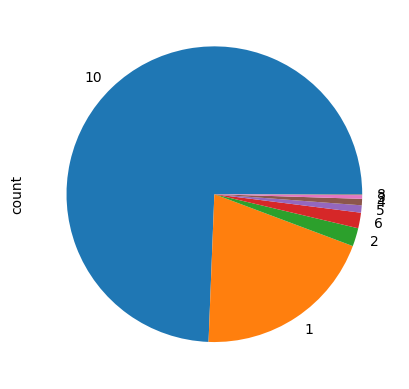

In [ ]:
# pie chart of number of blocks per prompt
df_count["n_blocks"].value_counts().plot.pie();

In [ ]:
# clculate the number of saved evaluations, so how many differ by how much from 10 in n_blocks
df_count["n_blocks_diff"] = abs(df_count["n_blocks"] - 10)
n_blocks_diff_times_n = (
    df_count["n_blocks_diff"].value_counts() * df_count["n_blocks_diff"].value_counts().index
)
n_blocks_diff_times_n.sum()

2131

In [ ]:
# total number of evaluations
df_count["n_blocks"].sum()

7859

In [ ]:
# tokens saved
(n_blocks_diff_times_n.sum()) / (n_blocks_diff_times_n.sum() + df_count["n_blocks"].sum())

0.21331331331331332

In [ ]:
df_count["n_blocks"].describe()

count    999.000000
mean       7.866867
std        3.715495
min        1.000000
25%        6.000000
50%       10.000000
75%       10.000000
max       10.000000
Name: n_blocks, dtype: float64

In [ ]:
df

,step,timestamp,time_elapsed,score,prompt,input_tokens_meta_llm,output_tokens_meta_llm,input_tokens_downstream_llm,output_tokens_downstream_llm,test_score,total_tokens,output_tokens_downstream_llm_cum,output_tokens_meta_llm_cum,input_tokens_downstream_llm_cum,input_tokens_meta_llm_cum,n_shots,prompt_len
0,1,2025-03-16 13:17:26.164321,237.770440,0.574699,Solve the given grade school math word problem...,1244,429,320898,70091,0.524,392662,70091,429,320898,1244,6,2659
1,1,2025-03-16 13:17:26.164321,237.770440,0.463391,Solve step-by-step. Final answer between <fina...,1244,429,320898,70091,0.346,785324,140182,858,641796,2488,1,325
2,1,2025-03-16 13:17:26.164321,237.770440,0.387952,Solve this math word problem using step-by-ste...,1244,429,320898,70091,0.296,1177986,210273,1287,962694,3732,3,1203
3,1,2025-03-16 13:17:26.164321,237.770440,0.374096,Solve this math problem by breaking it down in...,1244,429,320898,70091,0.386,1570648,280364,1716,1283592,4976,6,2563
4,1,2025-03-16 13:17:26.164321,237.770440,0.350665,Break down this word problem carefully. Rememb...,1244,429,320898,70091,0.344,1963310,350455,2145,1604490,6220,3,1566
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,64,2025-03-16 15:10:30.586841,72.124809,0.496561,Address the provided grade school math word pr...,1700,796,79344,23203,0.450,158568932,36382112,584060,120346788,1255972,5,2171
764,64,2025-03-16 15:10:30.586841,72.124809,0.482756,Adress the given grade school math word proble...,1700,796,79344,23203,0.466,158673975,36405315,584856,120426132,1257672,2,1708
765,64,2025-03-16 15:10:30.586841,72.124809,0.457430,Solve this math problem by breaking it down in...,1700,796,79344,23203,0.386,158779018,36428518,585652,120505476,1259372,6,2563
766,64,2025-03-16 15:10:30.586841,72.124809,0.438479,Approach this mathematical challenge by dissec...,1700,796,79344,23203,0.312,158884061,36451721,586448,120584820,1261072,2,1249
